# COVID-19 Deaths model

The next challenge is to implement a model for deaths. I'll start with the previous cumulative model, but I really want to make that a bit more intelligent. It always tends to flatten out too early.

Let's import the same data (to save time).

In [1]:
!pip install arviz pymc3==3.8
import numpy as np
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
import theano

# Load data
df = pd.read_csv("https://opendata.ecdc.europa.eu/covid19/casedistribution/csv/", parse_dates=["dateRep"], infer_datetime_format=True, dayfirst=True)
df = df.rename(columns={'dateRep': 'date', 'countriesAndTerritories': 'country'}) # Sane column names
df = df.drop(["day", "month", "year", "geoId"], axis=1) # Not required

# Create DF with sorted index
sorted_data = df.set_index(df["date"]).sort_index()
sorted_data["cumulative_cases"] = sorted_data.groupby(by="country")["cases"].cumsum()
sorted_data["cumulative_deaths"] = sorted_data.groupby(by="country")["deaths"].cumsum()

# Filter out data with less than 500 deaths, we probably can't get very good estimates from these.
sorted_data = sorted_data[sorted_data["cumulative_deaths"] >= 500]

# Remove "Czechia" it has a population of NaN
sorted_data = sorted_data[sorted_data["country"] != "Czechia"]

# Get final list of countries
countries = sorted_data["country"].unique()
n_countries = len(countries)

# Pull out population size per country
populations = {country: df[df["country"] == country].iloc[0]["popData2018"] for country in countries}

# A map from country to integer index (for the model)
idx_country = pd.Index(countries).get_indexer(sorted_data.country)

# Create a new column with the number of days since first infection (the x-axis)
country_first_dates = {c: sorted_data[sorted_data["country"] == c].index.min() for c in countries}
sorted_data["100_cases"] = sorted_data.apply(lambda x: country_first_dates[x.country], axis=1)
sorted_data["days_since_100_cases"] = (sorted_data.index - sorted_data["100_cases"]).apply(lambda x: x.days)

Let's plot a few countries to see what it looks like...

In [2]:
sorted_data[sorted_data["country"] == "United_Kingdom"]["deaths"].plot(label="UK")
sorted_data[sorted_data["country"] == "Spain"]["deaths"].plot(label="Spain")
sorted_data[sorted_data["country"] == "Italy"]["deaths"].plot(label="Italy")
sorted_data[sorted_data["country"] == "United_States_of_America"]["deaths"].plot(label="USA")
plt.legend()

In [3]:
def C(K, r, t, C_0):
  A = (K-C_0)/C_0
  return K / (1 + A * np.exp(-r * t))

def d_C(K, r, t, C_0):
  c = C(K, r, t, C_0)
  return r * c * (1 - c / K)

x = np.arange(len(sorted_data[sorted_data["country"] == "United_Kingdom"]))
plt.plot(x, d_C(19000, 0.22, x, 500), "r")
plt.plot(x, sorted_data[sorted_data["country"] == "United_Kingdom"]["deaths"], ".k")
plt.show()

There's a lot of noise near the peak. But I noticed that when we plot the same data on a log scale, the noise looks almost normally distributed.

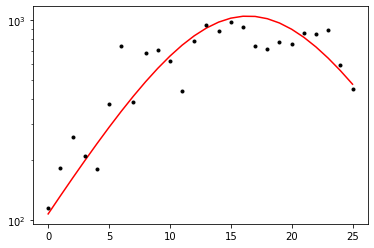

Minimum value in data:  115


In [4]:
x = np.arange(len(sorted_data[sorted_data["country"] == "United_Kingdom"]))
plt.plot(x, d_C(19000, 0.22, x, 500), "r")
plt.plot(x, sorted_data[sorted_data["country"] == "United_Kingdom"]["deaths"], ".k")
plt.yscale("log")
plt.show()

print("Minimum value in data: ", sorted_data[sorted_data["country"] == "United_Kingdom"]["deaths"].min())

But darn, there's lots of zeros in the data. Also, this tends to over-emphasise the small numbers of deaths, whereas the error in the large number's corresponds to the majority of the absolute error. So I'd prefer a better fit nearer the peak.

Let me revert back to the cumulative data.

In [5]:
x = np.arange(len(sorted_data[sorted_data["country"] == "United_Kingdom"]))
plt.plot(x, C(19000, 0.22, x, 500), "r")
plt.plot(x, sorted_data[sorted_data["country"] == "United_Kingdom"]["deaths"].cumsum(), ".k")
plt.yscale("log")
plt.show()

print("Minimum value in data: ", sorted_data[sorted_data["country"] == "United_Kingdom"]["deaths"].min())

Minimum value in data:  115


You can see that the curve isn't quite logistic. It's more polynomial. As countries take different measures to limit the infection rate, the rate of deaths is changing.

But to keep it simple and to get something working, let me stick to the old logistic model.

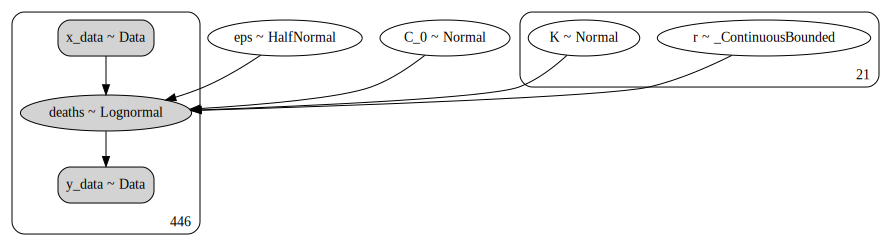

In [6]:
model = pm.Model()
with model:
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    t = pm.Data("x_data", sorted_data["days_since_100_cases"])
    y = pm.Data("y_data", sorted_data["cumulative_deaths"])

    # Intercept - We fixed this at 100.
    C_0 = pm.Normal("C_0", mu=100, sigma=10)

    # Growth rate: 0.2 is approx value reported by others
    r = BoundedNormal("r", mu=0.2, sigma=0.1, shape=n_countries)

    # Total number of cases. Depends on the population, more people, more infections.
    K = pm.Normal("K", mu=20000, sigma=20000*0.1, shape=n_countries)

    # Logistic regression
    growth = C(K[idx_country], r[idx_country], t, C_0)

    # Likelihood error
    eps = pm.HalfNormal("eps")

    # Likelihood - Counts here, so poission or negative binomial. Causes issues. Lognormal tends to work better?
    pm.Lognormal("deaths", mu=np.log(growth), sigma=eps, observed=y)

pm.model_to_graphviz(model)

In [7]:
for RV in model.basic_RVs:
    print(RV.name, RV.logp(model.test_point))

C_0 -3.2215236261987186
r_lowerbound__ -642.9434222444232
K -178.91666084768187
eps_log__ -0.7698925914732455
deaths -4796.387430310156


In [8]:
with model:
  trace = pm.sample(chains=2)
pm.traceplot(trace);
# pm.forestplot(trace, var_names=["K"]);
# pm.forestplot(trace, var_names=["r"]);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [eps, K, r, C_0]
Sampling chain 1, 0 divergences: 100%|██████████| 1000/1000 [00:04<00:00, 225.98it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


In [9]:
with model:
  ppc = pm.sample_posterior_predictive(trace)

100%|██████████| 1000/1000 [00:10<00:00, 98.34it/s]


In [10]:
idx = sorted_data["country"] == "United_Kingdom"
x = sorted_data["days_since_100_cases"]
y = sorted_data["cumulative_deaths"]
y_pred = ppc["deaths"].mean(axis=0)
plt.plot(x[idx], y_pred[idx], "r")
plt.plot(x[idx], y[idx], ".k")
plt.yscale("log")
plt.show()

In [11]:
y_residuals = ppc["deaths"].T - np.repeat(y_pred, 1000).reshape(len(y_pred),1000)
plt.plot(x[idx], y_residuals[idx], ".k", alpha=0.1)
plt.plot(x[idx], y[idx], ".r")
plt.show()

In [12]:
comparison = pm.compare(
    {
      model.name: trace, 
    }, ic='LOO');
print(comparison)
# pm.compareplot(comparison);

 rank      loo    p_loo d_loo weight       se dse warning loo_scale
    0 -3728.07  16.7952     0      1  20.2647   0    True       log


/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:532: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
